# Klaus' Setup:<br>Layerwise Relevance Propagation
***

This script uses the model saved in part 4 and computes Relevance scores using LRP

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
import pandas as pd 
import scipy.stats as st
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xarray as xr

<br>

## 1. Load Data
***

In [2]:
with xr.open_dataset('data/da_final_klausmodel.nc') as ds:
    features = ds.feat_pc.values
    labels = ds.labels.values
    originals_standardized = pd.DataFrame(
        data = ds.feat_standardized.values,
        columns = ds.indices.values,
        index = ds.year.values
    )

<br>

## 2. Load Model
---

In [3]:
model = keras.models.load_model('evaluation/klausmodel/model.h5')

<br>

## 3. Split Data and Predict
---

In [4]:
splits = [{'train': t, 'test': s} for t, s in KFold(n_splits=10, shuffle=True, random_state=712).split(features)]
train_index = shuffle(splits[-1]['train'], random_state=712)
test_index  = shuffle(splits[-1]['test'], random_state=712)


y_train= np.squeeze(model.predict(features[train_index]))
y_test = np.squeeze(model.predict(features[test_index]))

<br>

## 4. LRP
---

In [5]:
def lrp(index):
    
    W = [layer.get_weights() for layer in model.layers[::-1] if not 'Drop' in layer.name]
    L = len(W)
    
    R = np.zeros((len(index),26))
    
    for i in range(len(index)):
    
        # FORWARD PASS:
        A = [features[index[i]]]+[None]*L
        for l in range(L - 1):
            A[l+1] = np.maximum(0, np.matmul(A[l],W[-1-l][0]) + W[-1 -l][1])
        A[-1] = np.matmul(A[-2],W[0][0]) + W[0][1]
        A= A[::-1]
        

        # BACKWARD RELEVANCE COMPUTATION:
        R_weights = [np.squeeze(A[0])]
        R_biases = []

        for lay in range(L):

            w_jk = W[lay][0]                     # w_jk.shape = (lowerlayer, currentlayer)
            b_jk = W[lay][1]                     # biases 
            a_j  = np.squeeze(A[lay+1]).T        # activation lower layer

            z_k = a_j.dot(w_jk) + b_jk           # Step 1: for all k -> dotproduct along 1st dim (lowerlayer)
            s_k = R_weights[lay] / (z_k + 1e-9)  # Step 2: for all k -> element-wise operation
            c_j = s_k.dot(w_jk.T)                # Step 3: for all j -> dotproduct along 2nd dim (currentlayer)
            R_weights.append(a_j * c_j)          # STep 4: for all j -> element-wise operation
            R_biases.append(s_k.dot(b_jk))       # First element is highest layer


        R[i,:20] = R_weights[-1]
        R[i,20:] = R_biases
    
    eof = np.abs(xr.open_dataset('data/da_final_klausmodel.nc').pca_components.values)
    eof = (eof.T/eof.sum(1)).T  
    
    R_indices = np.matmul(R[:,:20], eof)
    R_indices = np.concatenate((R_indices,R[:,20:]), axis=1)
    
    R_indices = pd.DataFrame(
        data = R_indices,
        columns = xr.open_dataset('data/da_final_klausmodel.nc').indices.values.tolist() + [f'Bias L{i}' for i in range(6, 0,-1)]
    )
    
    R = pd.DataFrame(
        data = R, # already centered '- pca.mean_' not necessary
        columns = [f'PC{i}' for i in range(1, 21)] + [f'Bias L{i}' for i in range(6, 0,-1)]
    )
    
    return R, R_indices

In [6]:
train_r, train_r_indices = lrp(train_index)
test_r, test_r_indices = lrp(test_index)

<br>

## 5. Plot
---

<br>

### Principal Components
---

In [7]:
def compilation_plot(R, y, index, name,lim=0.6, width=9):
    i = np.argsort(labels[index])[::-1]

    f, axs = plt.subplots(2, 1, figsize=(width, 5), sharex=True, constrained_layout=True, gridspec_kw={'height_ratios': [1, 2]})#, gridspec_kw=dict(vspace=0))

    gr = sns.heatmap(R.T.iloc[:,i],                
                     fmt = '',
                     cmap="vlag_r",
                     vmin=-lim,
                     vmax=lim,
                     ax=axs[1]
                    )
    gr.set(xticklabels=[])
    axs[0].plot(np.arange(0.5,len(index)+0.5),labels[index][i], label="y-original")
    axs[0].plot(np.arange(0.5,len(index)+0.5), y[i], label="y-predicted")
    axs[0].legend()
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['bottom'].set_position('zero')
    # ax.spines['bottom'].set_position('center')
    # plt.subplots_adjust(hspace = .1)

    plt.savefig(f'./overleaf/img/klausmodel_lrp_{name}.pdf', facecolor='w')

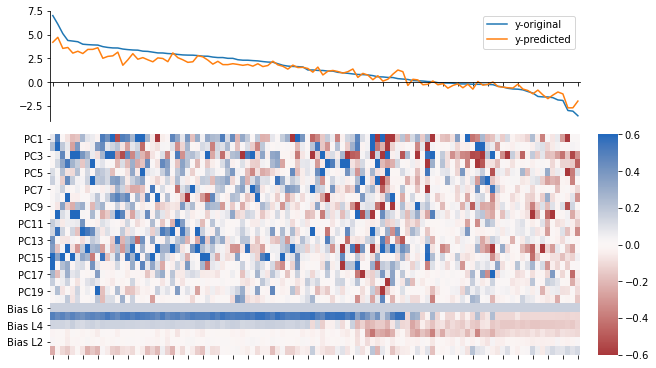

In [8]:
compilation_plot(train_r, y_train, train_index, 'pc_train')

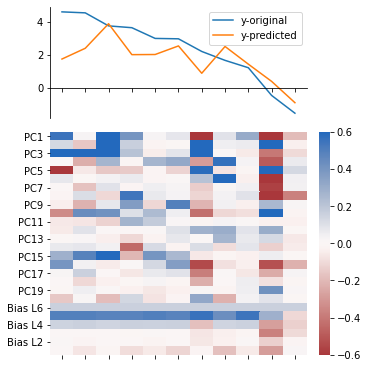

In [9]:
compilation_plot(test_r, y_test, test_index, 'pc_test', width=5)

<br>

### Indices
---

In [10]:
def compilation_plot_large(R, clim_indices, y, index, name, lim1=.2, lim2=1.5, width=9):

    i = np.argsort(labels[index])[::-1]

    f, axs = plt.subplots(3, 1, figsize=(width, 12), sharex=True, constrained_layout=True, gridspec_kw={'height_ratios': [1, 6, 4]})#, gridspec_kw=dict(vspace=0))

    gr = sns.heatmap(R.T.iloc[:,i],                
                     fmt = '',
                     cmap="vlag_r",
                     vmin=-lim1,
                     vmax=lim1,
                     ax=axs[1])
    gr.set(xticklabels=[])
    gr = sns.heatmap(clim_indices.T.iloc[:,i],                
                 fmt = '',
                 cmap="vlag_r",
                 vmin=-lim2,
                 vmax=lim2,
                 ax=axs[2])
    gr.set(xticklabels=[])
    axs[0].plot(np.arange(0.5,len(index)+0.5), labels[index][i], label="y-original")
    axs[0].plot(np.arange(0.5,len(index)+0.5), y[i], label="y-predicted")
    axs[0].legend()
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['bottom'].set_position('zero')
    # ax.spines['bottom'].set_position('center')
    # plt.subplots_adjust(hspace = .1)

    plt.savefig(f'./overleaf/img/klausmodel_lrp_{name}.pdf', facecolor='w')

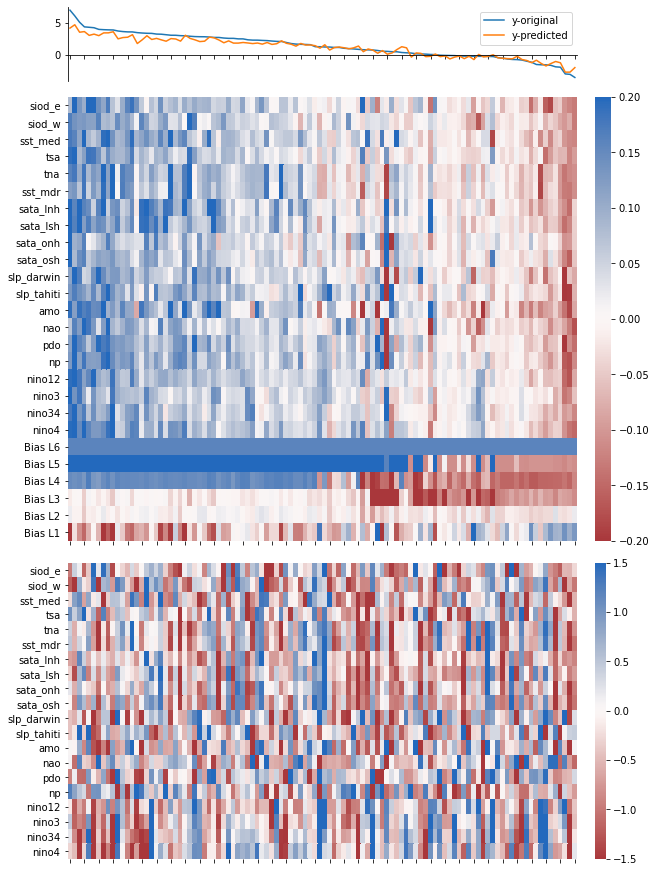

In [11]:
compilation_plot_large(train_r_indices, originals_standardized ,y_train, train_index, 'indices_train')

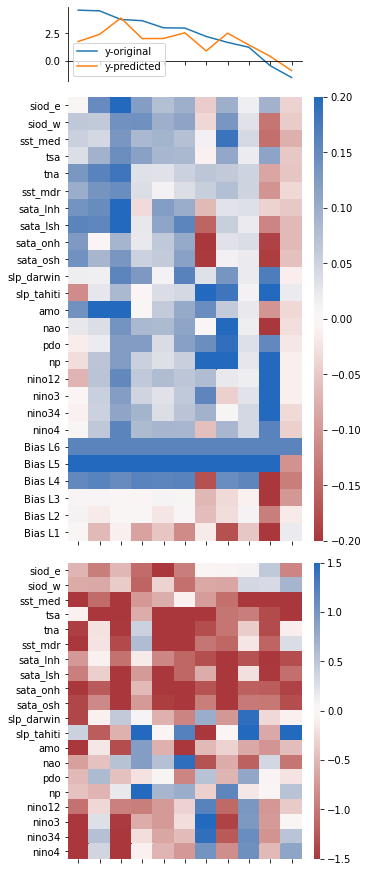

In [12]:
compilation_plot_large(test_r_indices, originals_standardized, y_test, test_index, 'indices_test', width=5)

<br>

### Filtered Extremes
---

In [13]:
def relevance_filter_plot(R, clim_indices, y, index, name, n_extrems=3, fraction_of_relevance=.6, lim1=.2, lim2=1.5, width=5): #R, clim_indices, y, index, name, lim1=.5, lim2=1.5, width=9
    
    i = np.argsort(labels[index])[::-1]
    i = np.concatenate((i[:n_extrems],i[-n_extrems:]))
    df = R.T.loc[:,i]
    
    for _,item in df.iteritems():
        total = item.abs().sum()
        top = item.abs().sort_values(axis=0, ascending=False).cumsum()
        ind = top.where(top >= total*fraction_of_relevance).idxmin()
        ind = top.loc[ind:].index[1:]
        item.loc[ind] = np.nan
    
    f, axs = plt.subplots(3, 1, figsize=(width, 12), sharex=True, constrained_layout=True, gridspec_kw={'height_ratios': [1, 7, 5]})#, gridspec_kw=dict(vspace=0))

    gr = sns.heatmap(df,                
                     fmt = '',
                     cmap="vlag_r",
                     vmin=-lim1,
                     vmax=lim1,
                     ax=axs[1])
    gr.set(xticklabels=[])

    gr = sns.heatmap(clim_indices.T.iloc[:,i],                
                 fmt = '',
                 cmap="vlag_r",
                 vmin=-lim2,
                 vmax=lim2,
                 ax=axs[2])
    gr.set(xticklabels=[])
    axs[0].plot(np.arange(0.5,len(i)+0.5), labels[index][i], label="y-original")
    axs[0].plot(np.arange(0.5,len(i)+0.5), y[i], label="y-predicted")
    axs[0].legend()
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['bottom'].set_position('zero')
    # ax.spines['bottom'].set_position('center')
    # plt.subplots_adjust(hspace = .1)

    plt.savefig(f'./overleaf/img/klausmodel_lrp_{name}.pdf', facecolor='w')    
    return df

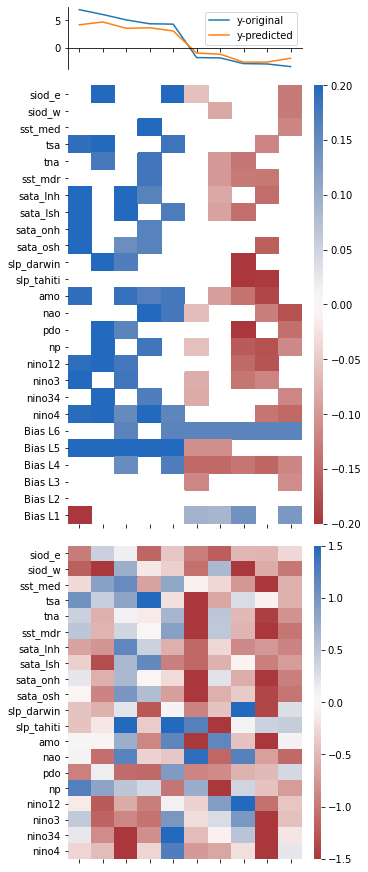

In [14]:
bli = relevance_filter_plot(train_r_indices, originals_standardized ,y_train, train_index, 'indices_filtered_train', 5)

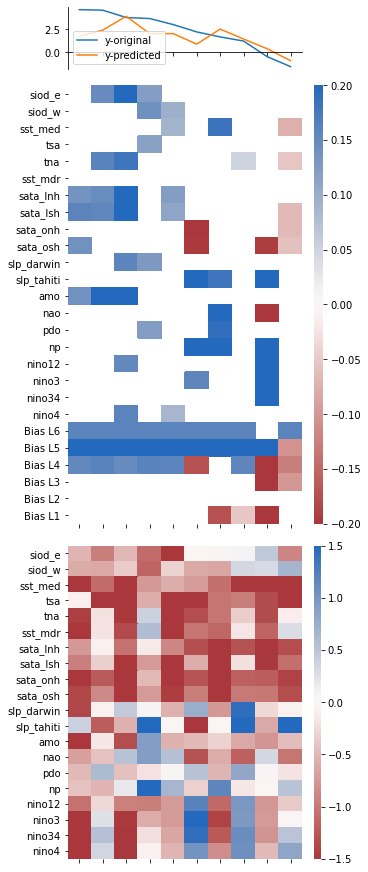

In [15]:
bla = relevance_filter_plot(test_r_indices, originals_standardized ,y_test, test_index, 'indices_filtered_test', 5)